# Analysis of scRNA-seq data from activated PBMCs in TWINS only

In CVID and healthy control, 10X platform

09.02.2021: reanalysis, correcting the bug in bertie function

(Preprocessing happened in notebook M0)

Step-by-step workflow - **different to the scRNA-seq integration in doublet calling**:
- load preprocessed object
- do SCTransfor instead of normalising & log transforming
- save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- filter out cell cycle genes
- subset to HVGs
- (skipping scaling, not necessary because we've done SCTransform)
- pca (can also do preliminary neighbors/bbknn+umap here to peak at the data)
- **train a logreg model and add annotation (before it used to be earlier in the workflow)**
- neighbors/bbknn - deciding on which batch correction we will be using
- perform **step 2** of bertie doublet calling (requires running louvain clustering, see code)
- umap
- unbiased clustering
- save

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.6.2
alembic==1.3.0
anndata==0.6.22.post1
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
Click==7.0
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==1.0
h5py==2.10.0
idna==2.8
imageio==2.9.0
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.0.3
mistune==0.8.4
more-itertools==7.2.0
multidict==4.5.2
natsort==6.2.0
nb-co

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


A Benjamini-Hochberg function for later. Running FDR is surprisingly inconvenient using built-in Python options.

In [6]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'

## Reding the preprocessed object

Preprocessing happened in M1-0 notebook, preliminary analysis - in notebook M1-1

In [7]:
# reading
adata = sc.read(save_path+'adata_raw_filtered.h5ad')

In [16]:
adata

AnnData object with n_obs × n_vars = 17662 × 17976 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [13]:
# reading indices of cells that were not called as doublets
indices = pd.read_csv('./cells_no_doublets_twins.csv', index_col=0)['index']

In [14]:
indices

0        AAACCTGCAGACAAGC-1
1        AAACCTGCATGTTCCC-1
2        AAACCTGGTCTCTCTG-1
3        AAACCTGTCGAACTGT-1
4        AAACGGGAGATGAGAG-1
                ...        
17310    TTTGTCACATCGTCGG-1
17311    TTTGTCAGTAAATGTG-1
17312    TTTGTCAGTATCTGCA-1
17313    TTTGTCAGTCAATACC-1
17314    TTTGTCAGTTGAACTC-1
Name: index, Length: 17315, dtype: object

In [15]:
len(set(adata.obs_names) & set(indices))

17315

In [20]:
adata = adata[list(set(adata.obs_names) & set(indices)),:].copy()

In [21]:
adata

AnnData object with n_obs × n_vars = 17315 × 17976 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

In [18]:
# to gain donor information reading preliminarily analysed object
#adata_prelim = sc.read(save_path+'adata_hvg_prelim_analysis_all_samples.h5ad')

In [19]:
#adata_prelim

In [22]:
# transferring metadata
#for col in adata_prelim.obs.columns:
#    adata.obs[col] = adata_prelim.obs.loc[adata.obs_names,col]

In [23]:
np.unique(adata.obs['sample'])

array(['Immunodeficiency8103070', 'Immunodeficiency8103072',
       'Immunodeficiency8103073', 'Immunodeficiency8103074',
       'Immunodeficiency8103076', 'Immunodeficiency8103077'], dtype=object)

In [24]:
expr_mtx_check = adata[adata.obs['sample'] == 'Immunodeficiency8103070'].X.todense()
np.unique(expr_mtx_check)

matrix([[   0.,    0.,    0., ..., 2261., 2508., 2668.]], dtype=float32)

___________

Carrying on to 
- Normalise and log transform
- Save raw attribute to then be able to plot all genes on the HVG-subsetted dataset
- Make cell names (obs) and gene names (var) unique

In [25]:
# normalise and log transform
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

# saving the raw attribute
adata.raw = adata.copy()

adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Second step of bertie doublet removal - will be done later in the pipeline

_____________________________________________________________________________________________________________________________________________________________

### Filter Cell cycle genes 
Per genes analysis: identify genes behaving like known cell cycle genes

There are no cycle genes, so skipping this here

extracting highly variable genes
    finished (0:00:03)


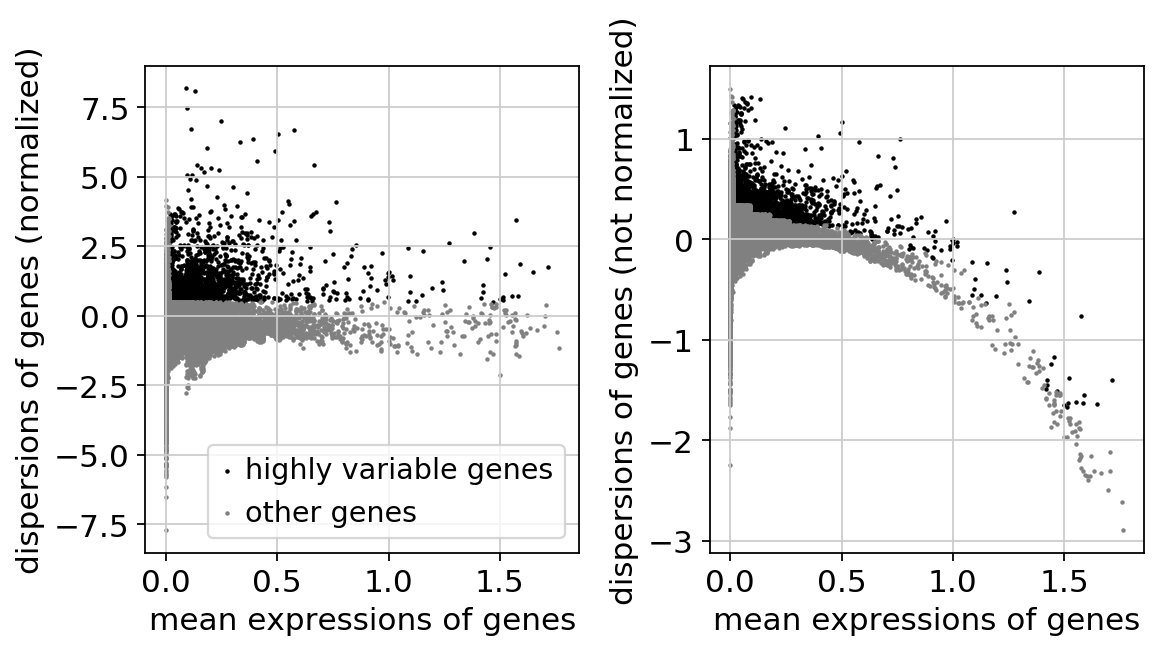

In [26]:
cellcycle_adata = adata.copy()
# Extract highly variable genes
filter_result = sc.pp.filter_genes_dispersion(
    cellcycle_adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result,save='_ccg_identification.pdf')

In [27]:
# Traspose matrix for a GENE-centered analysis
cellcycle_adata = cellcycle_adata.T
cellcycle_adata = cellcycle_adata[filter_result.gene_subset,:]


In [28]:
%%time
# Scale data to unit variance and zero mean
sc.pp.scale(cellcycle_adata, max_value=10)
# Scatter plot in PCA coordinates
sc.tl.pca(cellcycle_adata, n_comps=30)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 30
    finished (0:00:01)
CPU times: user 6.84 s, sys: 14.9 s, total: 21.7 s
Wall time: 1.99 s


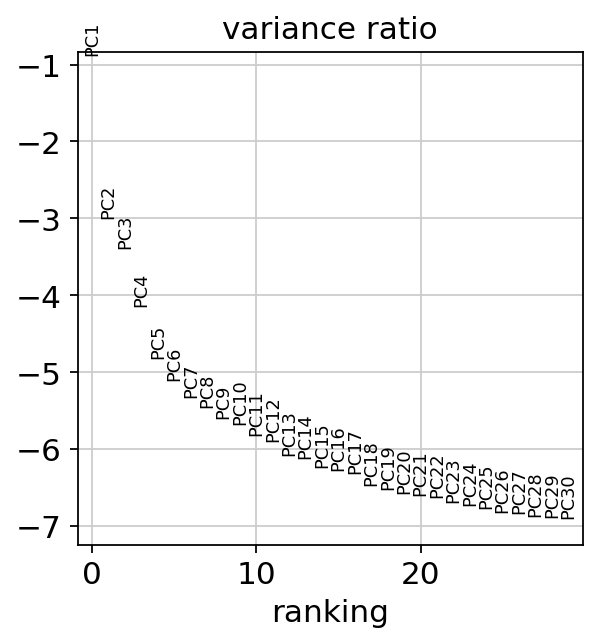

In [29]:
# Plot the variance ratio
sc.pl.pca_variance_ratio(cellcycle_adata, log=True, save='_ccg_identification.pdf')

computing neighbors
    using 'X_pca' with n_pcs = 18
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


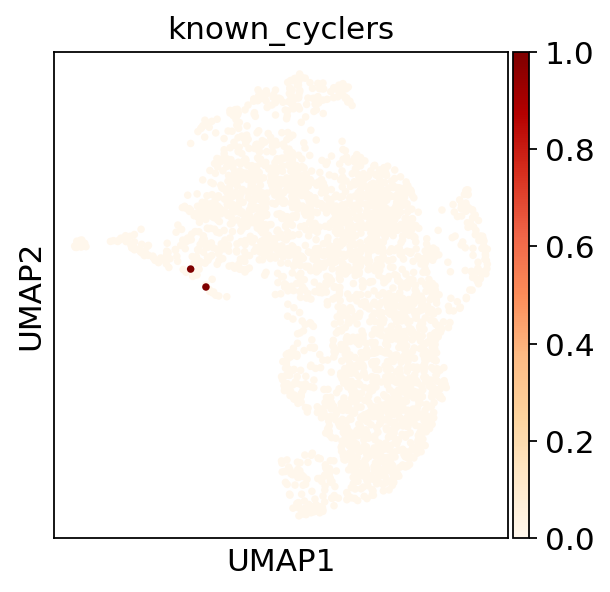

In [30]:
# Identify genes behaving like cc genes
num_pcs = 18
# Compute a neighborhood graph of observations
sc.pp.neighbors(cellcycle_adata,n_pcs=num_pcs)
# Embed the neighborhood graph using UMAP
sc.tl.umap(cellcycle_adata)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers'],color_map='OrRd',save='_ccg_identification.pdf')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 12 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


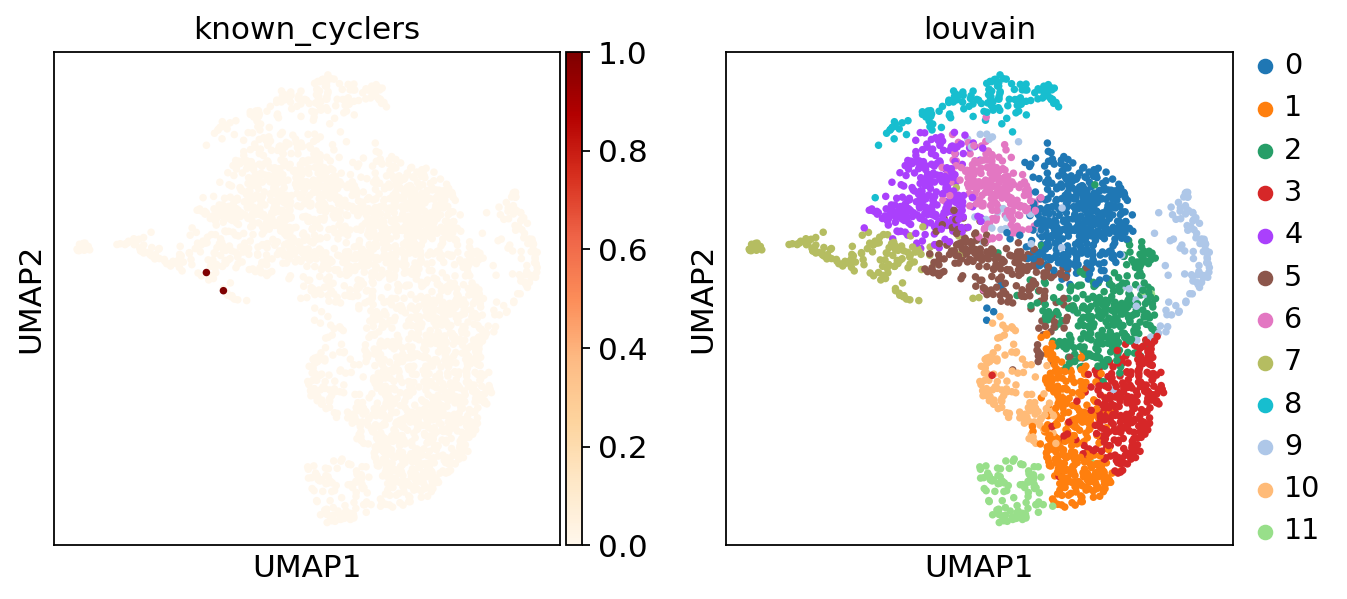

In [31]:
# Cluster GENES into subgroups using louvain
sc.tl.louvain(cellcycle_adata, resolution=1.0)
cellcycle_adata.obs['known_cyclers'] = [i in ['CDK1','MKI67','CCNB2','PCNA'] for i in cellcycle_adata.obs_names]
# Scatter plot in UMAP basis
sc.pl.umap(cellcycle_adata,color=['known_cyclers',
                                  'louvain'],color_map='OrRd',save='_ccg_identification.pdf')

In [32]:
# Locate genes of interests' cluster
print(cellcycle_adata.obs.loc[['CDK1','MKI67','CCNB2','PCNA'],'louvain'])


index
CDK1     NaN
MKI67      7
CCNB2    NaN
PCNA       7
Name: louvain, dtype: category
Categories (12, object): [0, 1, 2, 3, ..., 8, 9, 10, 11]


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [33]:
adata

AnnData object with n_obs × n_vars = 17315 × 17976 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'

So removing genes from cluster 7 by filtering the main matrix

In [34]:
# Add unstructured dict-like annotation for ccgs
adata.uns['ccgs'] = list(cellcycle_adata.obs[(cellcycle_adata.obs['louvain']=='7')].index)
# Remove cc genes
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]


In [35]:
adata

View of AnnData object with n_obs × n_vars = 17315 × 17833 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'ccgs'

In [36]:
%%time
# Assign cell cycle stage & scores
cell_cycle_genes = [x.strip() for x in open(file='/home/jovyan/notebooks/Vento_Lab/regev_lab_cell_cycle_genes_from_Luz_20200505.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

# takes a few minutes

calculating cell cycle phase
computing score 'S_score'


Trying to set attribute `.obs` of view, making a copy.


    finished: added
    'S_score', score of gene set (adata.obs) (0:00:05)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:05)
-->     'phase', cell cycle phase (adata.obs)
CPU times: user 3.34 s, sys: 7.99 s, total: 11.3 s
Wall time: 11.4 s


In [37]:
#adata.write(save_path+'adata_preproc_and_ccg_removed_nodoublets_GEX_only.h5ad')

In [38]:
#adata = sc.read(save_path+'adata_preproc_and_ccg_removed_nodoublets_GEX_only.h5ad')

In [39]:
adata

AnnData object with n_obs × n_vars = 17315 × 17833 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'ccgs'

_______________________________________________________________________________________________________

# ANNOTATION through LOGISTIC REGRESSION

In [40]:
# object from previous analysis of twins
# by mistake - data in .raw.X is normalised, log tr and scaled, so take .raw.X
adata_sc_annotated = sc.read('/home/jovyan/notebooks/Vento_Lab/CVID/GitHub_to_post/CVID_old_full/scTranscriptomics/adata_10X.h5ad')

In [41]:
adata_sc_annotated

AnnData object with n_obs × n_vars = 17662 × 4045 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'myel_refine'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_types-3',

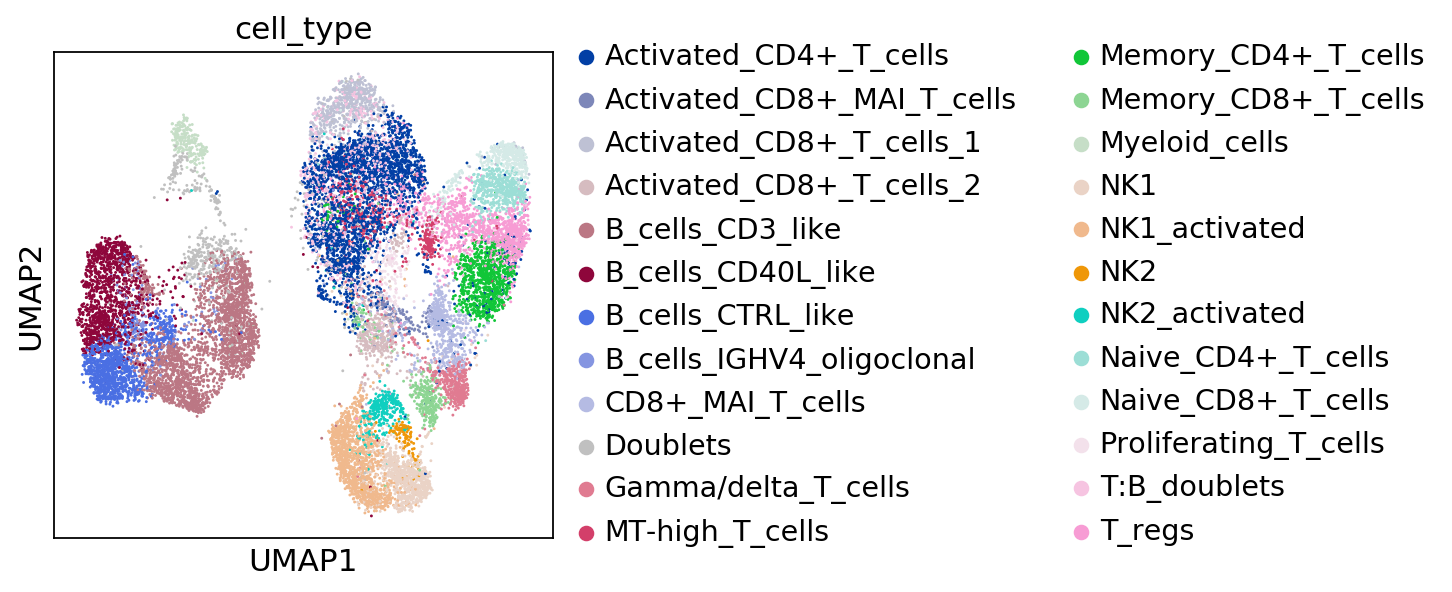

In [42]:
sc.pl.umap(adata_sc_annotated, color='cell_type')

In [43]:
np.unique(adata_sc_annotated.var['highly_variable'])

array([ True])

In [40]:
# these are HVGs
hvgs = adata_sc_annotated.var_names
len(hvgs)

1889

## Model trained on previous annotated scRNA-seq object (twins only, old analysis)

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [45]:
# annotated object, normalised, log transformed and scaled in .raw.X
# all genes
adata_train = anndata.AnnData(X = adata_sc_annotated.raw.X,
                              obs = adata_sc_annotated.obs,
                              var = adata_sc_annotated.raw.var)
# subsetting to HVG
#adata_train = adata_train[:,hvgs].copy()

In [46]:
# normalised, log transformed object, not scaled
adata_test = adata.copy()

# scaling the test object
sc.pp.scale(adata_test, max_value=10)

In [47]:
adata_train.obs.columns

Index(['activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes',
       'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score',
       'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain',
       'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B',
       'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7',
       'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra',
       'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections',
       'louvain_corrections_2', 'has_Bcell_vdj_data', 'myel_refine'],
      dtype='object')

In [48]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between annotated train and our joint data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

17832 genes are shared between annotated train and our joint data 
 17976 genes in training data 
 17833 genes in test joint data 



Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [49]:
adata_train_copy = adata_train[:,common_genes]

In [50]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=17832)

In [51]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=17832)

In [52]:
# checking gene correspondence - important!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [53]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['Activated_CD4+_T_cells', 'Activated_CD8+_MAI_T_cells',
        'Activated_CD8+_T_cells_1', 'Activated_CD8+_T_cells_2',
        'B_cells_CD3_like', 'B_cells_CD40L_like', 'B_cells_CTRL_like',
        'B_cells_IGHV4_oligoclonal', 'CD8+_MAI_T_cells', 'Doublets',
        'Gamma/delta_T_cells', 'MT-high_T_cells', 'Memory_CD4+_T_cells',
        'Memory_CD8+_T_cells', 'Myeloid_cells', 'NK1', 'NK1_activated',
        'NK2', 'NK2_activated', 'Naive_CD4+_T_cells', 'Naive_CD8+_T_cells',
        'Proliferating_T_cells', 'T:B_doublets', 'T_regs'], dtype=object),
 array([2573,  121,  604,  407, 2476, 1262, 1240,  173,  623,  516,  425,
         381,  889,  340,  231,  812, 1214,  115,  315,  524,  439,  170,
         604, 1208]))

## Training a logistic regression model on previously annotated 10X data from Roser+Suryawanshi

In [54]:
adata_train_copy.obs['cell_type'].head()

index
AAACCTGCAGACAAGC-1                    NK1
AAACCTGCATGTTCCC-1                    NK2
AAACCTGGTCTCTCTG-1          NK1_activated
AAACCTGTCGAACTGT-1    Memory_CD4+_T_cells
AAACGGGAGATGAGAG-1                 T_regs
Name: cell_type, dtype: category
Categories (24, object): [Activated_CD4+_T_cells, Activated_CD8+_MAI_T_cells, Activated_CD8+_T_cells_1, Activated_CD8+_T_cells_2, ..., Naive_CD8+_T_cells, Proliferating_T_cells, T:B_doublets, T_regs]

In [55]:
celltypes_train = adata_train_copy.obs['cell_type']

In [56]:
adata_train_copy.X.shape

(17662, 17832)

Using ONLY COMMON GENES

In [57]:
%time
# training a logistic regression model on scRNA-seq data
# takes 4-5 hours?
# started ~ at 19:37ish
logisticRegr_sc = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr_sc.fit(adata_train_copy.X, celltypes_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.58 µs


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [58]:
# Saving model trained on scRNA-seq
# already done
# logreg_sc_hvg.pkl was for the object in which ccgs are not removed
pkl_filename = "logreg_sc_from_old_twin_data.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr_sc, file)

In [21]:
# Load model (scRNA-seq) from file
pkl_filename = "logreg_sc_from_old_twin_data.pkl"
with open(pkl_filename, 'rb') as file:  
    logisticRegr_sc = pickle.load(file)

In [59]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 17662 × 17832 
    obs: 'activation', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'cell_id', 'seq_batch', 'louvain', 'is_doublet_poptrim', 'cell_type', 'louvain_R9', 'louvain_B', 'louvain_NK', 'louvain_NK_1', 'louvain_myel', 'louvain_R_Tcells_7', 'louvain_R_Tcells_24568', 'louvain_R_Tcells_24568_extra', 'louvain_R_Tcells_24568_extra_extra', 'louvain_corrections', 'louvain_corrections_2', 'has_Bcell_vdj_data', 'myel_refine'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'highly_variable-2', 'means-2', 'dispersions-2', 'dispersions_norm-2', 'gene_ids-3', 'feature_

In [60]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 17315 × 17832 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'ccgs'

In [61]:
logisticRegr_sc

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [62]:
%%time
predictions = logisticRegr_sc.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions'] = predictions

Trying to set attribute `.obs` of view, making a copy.


CPU times: user 6.54 s, sys: 8.91 s, total: 15.4 s
Wall time: 8.98 s


In [63]:
%%time
# probabilities
probabilities = logisticRegr_sc.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions']):
    probs_adata.append(probabilities[i,logisticRegr_sc.classes_==clus][0])


CPU times: user 2.97 s, sys: 1.8 s, total: 4.78 s
Wall time: 1.22 s


In [64]:
list(adata_test_copy.obs.index) == list(adata.obs.index)

True

In [65]:
adata.obs['probabilities'] = probs_adata

In [66]:
adata.obs['celltype_predictions'] = adata_test_copy.obs['celltype_predictions']

In [67]:
adata.obs.loc[:,['celltype_predictions','probabilities']].to_csv(save_path+'predictions_from_old_twin_10X_analysis.csv')

In [68]:
adata

AnnData object with n_obs × n_vars = 17315 × 17833 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    uns: 'ccgs'

# Subsetting to HVGs and scaling

In [69]:
%%time
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
CPU times: user 2.38 s, sys: 284 ms, total: 2.67 s
Wall time: 2.67 s


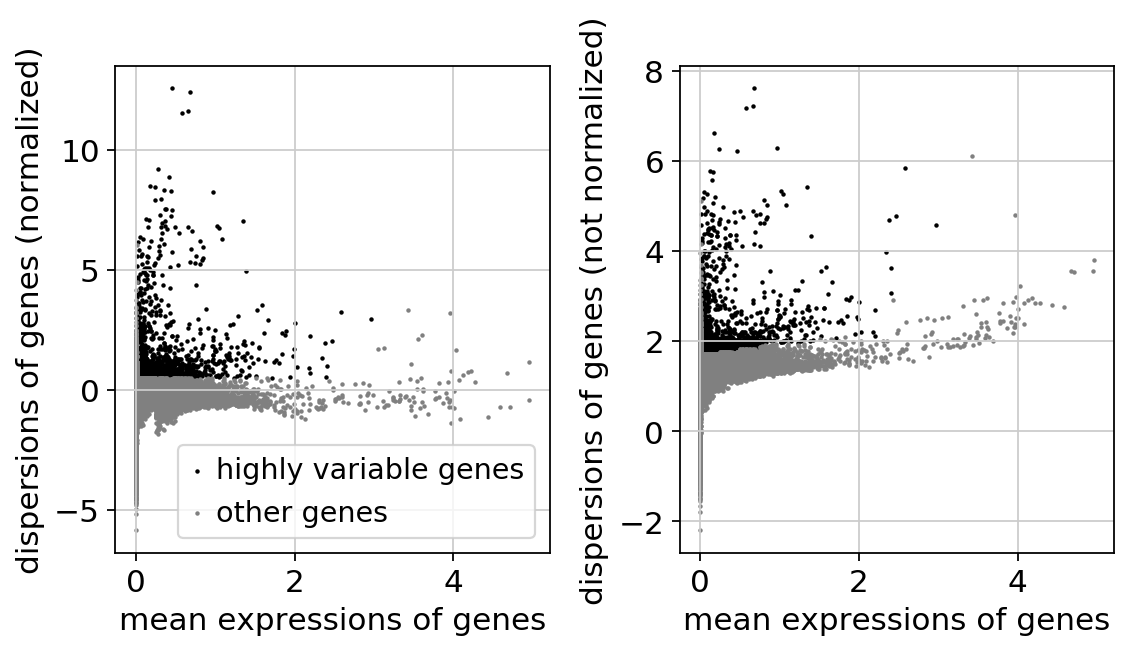

CPU times: user 1.09 s, sys: 692 ms, total: 1.78 s
Wall time: 815 ms


In [70]:
%%time
sc.pl.highly_variable_genes(adata)

In [71]:
adata_hvg = adata[:, adata.var['highly_variable']]

In [72]:
adata_hvg

View of AnnData object with n_obs × n_vars = 17315 × 2439 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ccgs'

In [73]:
%%time
sc.pp.scale(adata_hvg, max_value=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


CPU times: user 280 ms, sys: 568 ms, total: 848 ms
Wall time: 848 ms


________

## PCA

In [74]:
%%time
sc.tl.pca(adata_hvg, svd_solver='arpack', n_comps=50)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:07)
CPU times: user 36.2 s, sys: 1min 2s, total: 1min 38s
Wall time: 7.5 s


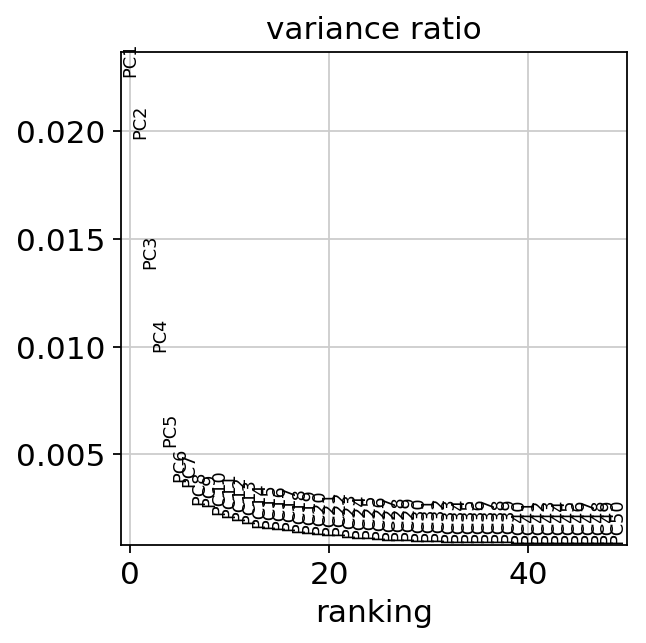

In [75]:
sc.pl.pca_variance_ratio(adata_hvg, n_pcs=50)

## OR

### Harmony

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:43)


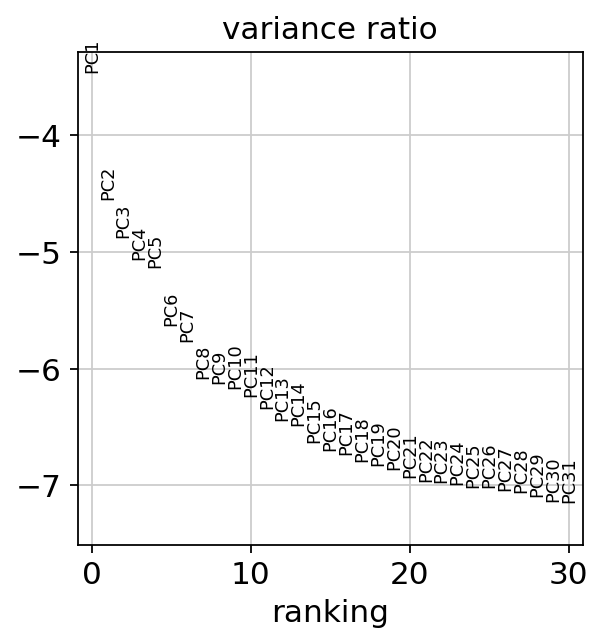

CPU times: user 3min 32s, sys: 3min 4s, total: 6min 37s
Wall time: 43.5 s


In [88]:
%%time
# trying out harmony here
# Check PCA again - needed for harmony - and extract PCA matrix and batch array
sc.tl.pca(adata_hvg)
n_pcs = 20
sc.pl.pca_variance_ratio(adata_hvg, log=True, save=False)
pca = adata_hvg.obsm['X_pca'][:, 0:n_pcs]
batch = adata_hvg.obs['sample']

In [89]:
# Batch-correct the PCA using HARMONY method
%load_ext rpy2.ipython

In [90]:
%%time
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem <- HarmonyMatrix(pca, batch, theta=1, do_pca=FALSE)
hem = data.frame(hem)


R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

CPU times: user 31min 41s, sys: 23min 42s, total: 55min 24s
Wall time: 25min 8s


In [91]:
# Add harmony values to the anndata object
adata_hvg.obsm['X_pca'] = hem.values

In [81]:
# the next 3 cells run harmonypy but unfortunately they take forever...

_______

### Neighbourhood graph & UMAP

__________________________________________________________________________________________________________________________________________________________________

In [92]:
%%time
sc.pp.neighbors(adata_hvg, n_neighbors=10, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20


/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/conda/lib/python3.7/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../opt/conda/lib/python3.7/site-packages/umap/nndes

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)
CPU times: user 38.1 s, sys: 1.22 s, total: 39.3 s
Wall time: 39.3 s


### OR

BBKNN by donor


In [76]:
%%time
bbknn.bbknn(adata_hvg, batch_key='sample')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:03)
CPU times: user 3.97 s, sys: 0 ns, total: 3.97 s
Wall time: 3.97 s


__________________________________________________________________________________________________________________________________________________________________

In [77]:
%%time
sc.tl.umap(adata_hvg, random_state=0)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)
CPU times: user 19 s, sys: 3.1 s, total: 22.1 s
Wall time: 17.9 s


# Plotting

In [78]:
adata_hvg

AnnData object with n_obs × n_vars = 17315 × 2439 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ccgs', 'pca', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [79]:
markers = ['CD4','CD3G', 'FOXJ1', 'IL2R', 'TRDV2', 'CD8', # T cells
                             'CD19', 'MS4A1', # B cells
                              'CD27', 'CD38', 'JCHAIN', # Plasma B cells
                             'NCAM1', 'FCGR3A', # NK celss
                             'HBB', # Erythrocytes
                             'FCGR3B', # Neutrophils
                             'CD14', 'S100A12', # Monocytes
                             'FLT3', # Dendritic cells
                             'IRF4', 'CLEC9A', # cDC1
                             'CD1C', # cDC2
                             'TNFRSF21', # pDC and IRF4
                             'CD34', # Precursors
                             'PPBP', 'TUBB1', 'PF4', # Platelets
                             'MI67', # cycling
                            ]

### BBKNN by `sample`

20 PCs

... storing 'phase' as categorical
... storing 'celltype_predictions' as categorical


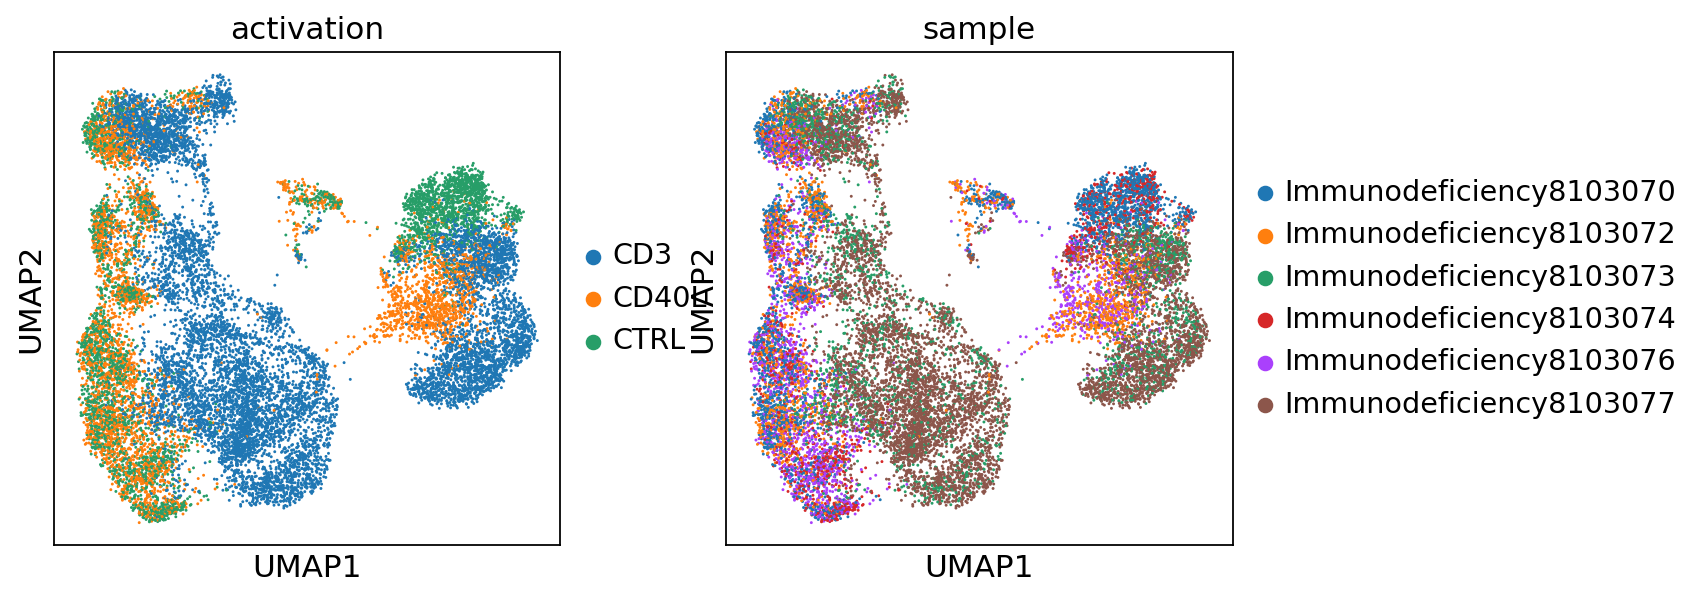

In [80]:
sc.pl.umap(adata_hvg, color=['activation','sample'])

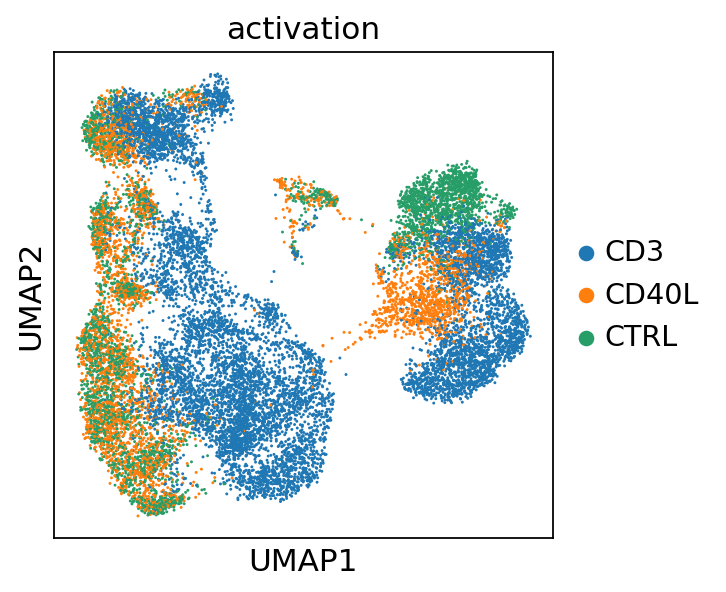

In [81]:
sc.pl.umap(adata_hvg, color=['activation'])

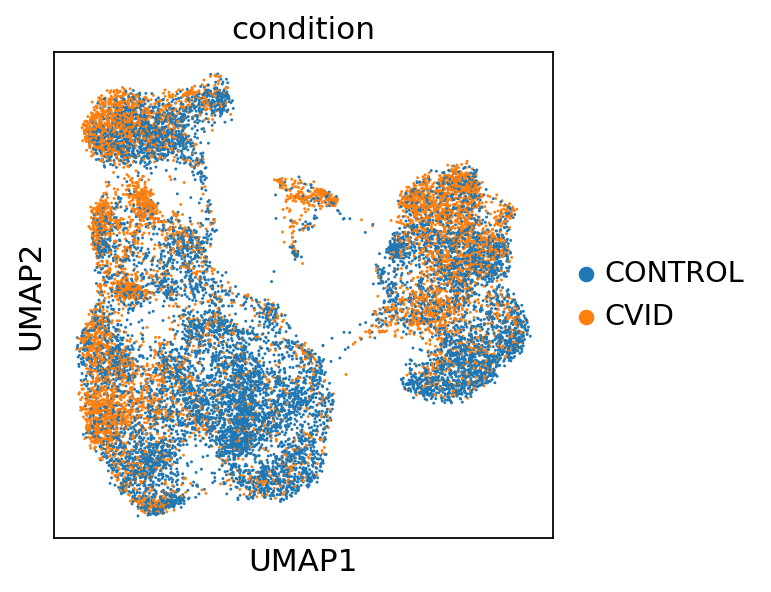

In [82]:
sc.pl.umap(adata_hvg, color=['condition'])

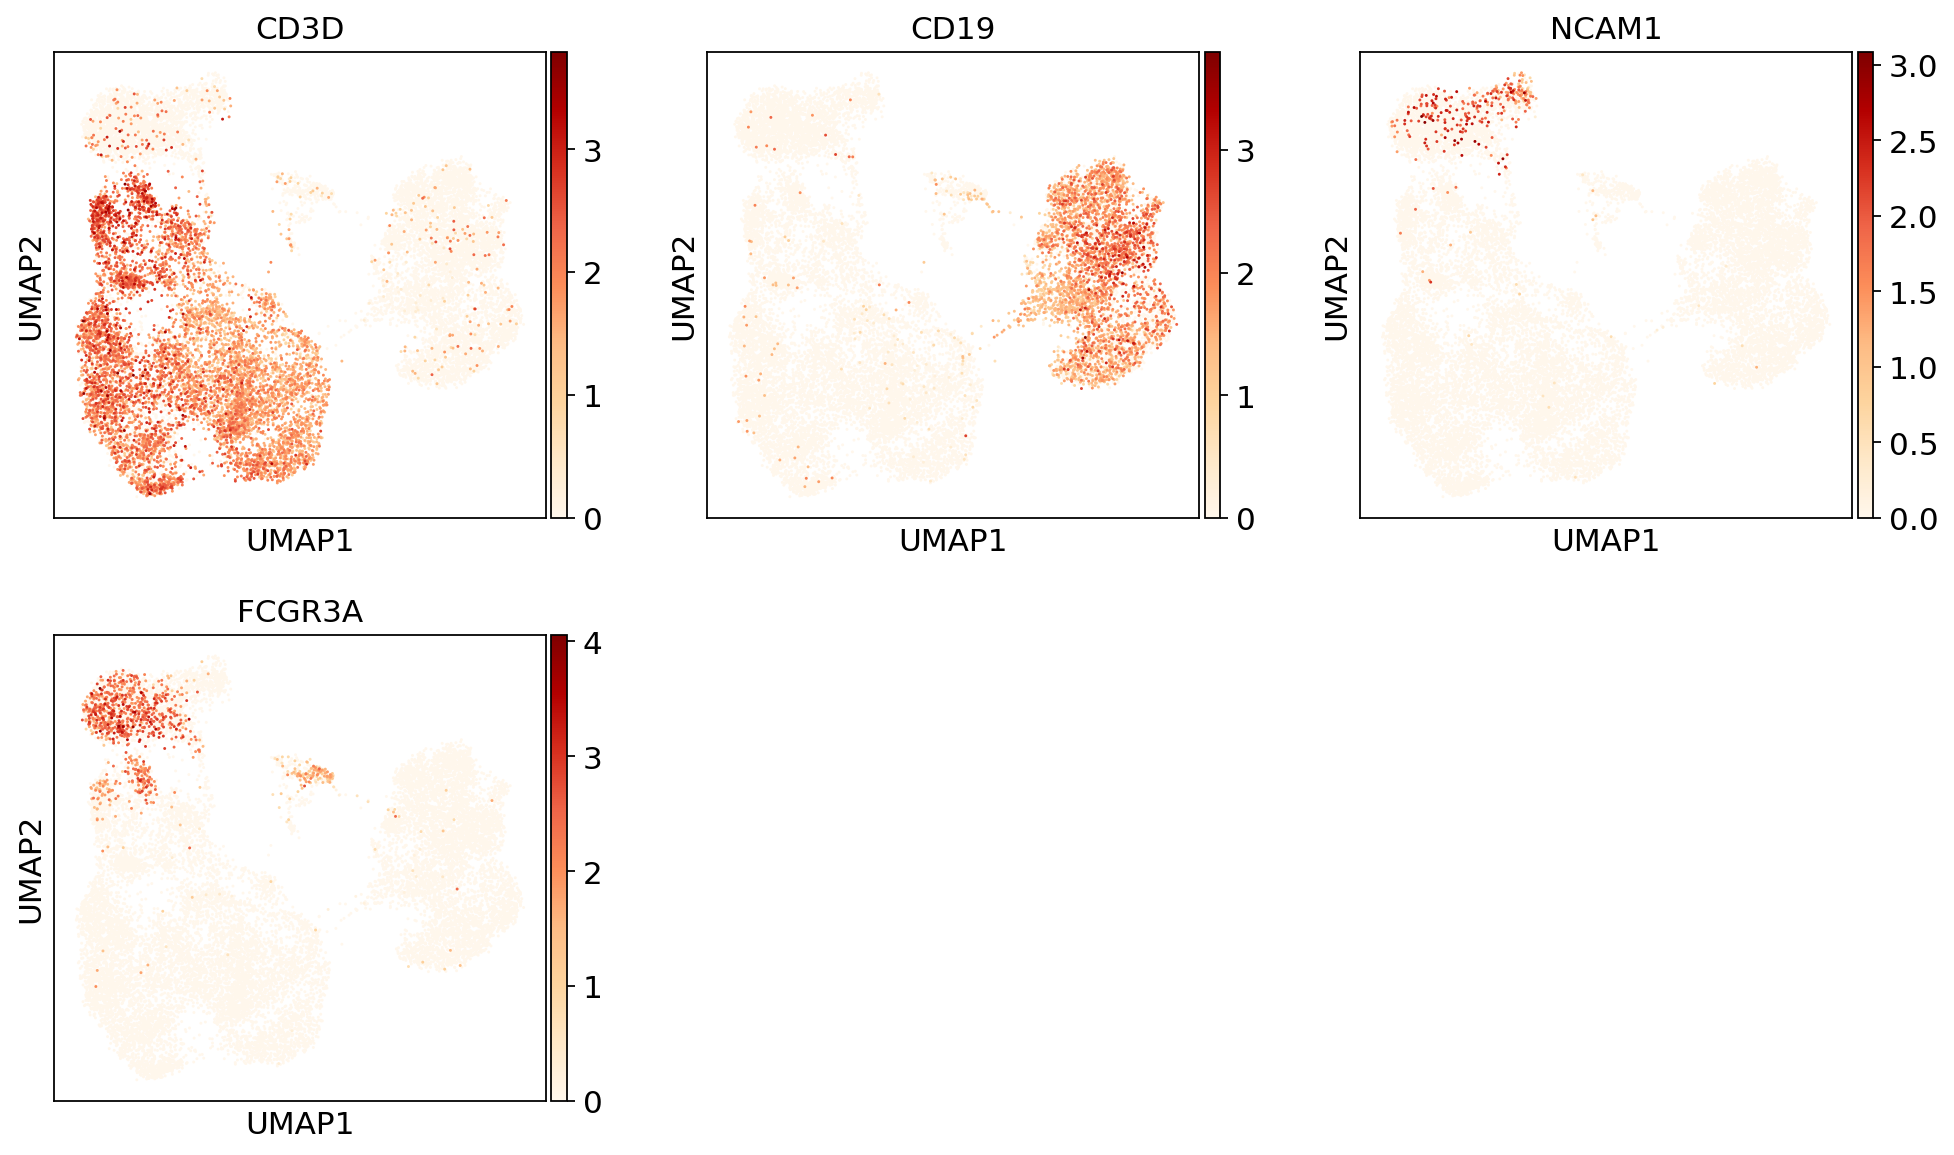

In [83]:
sc.pl.umap(adata_hvg, color=['CD3D', # T cells
                             'CD19', # B cells
                             # NK markers
                             'NCAM1', # CD56
                             'FCGR3A', # CD16
                            ], ncols=3, use_raw=True, cmap='OrRd')

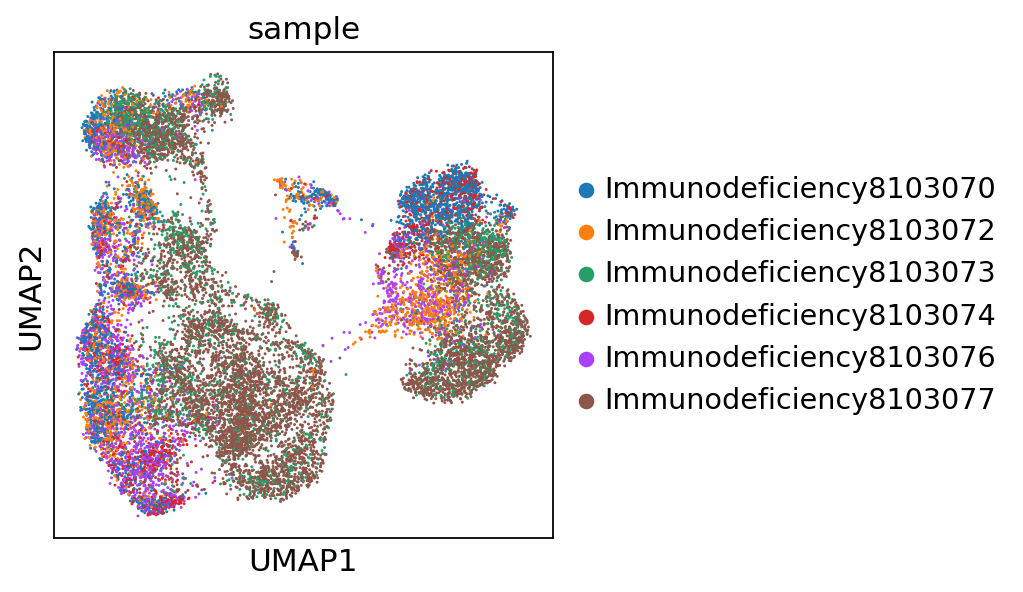

In [84]:
sc.pl.umap(adata_hvg, color=['sample'])

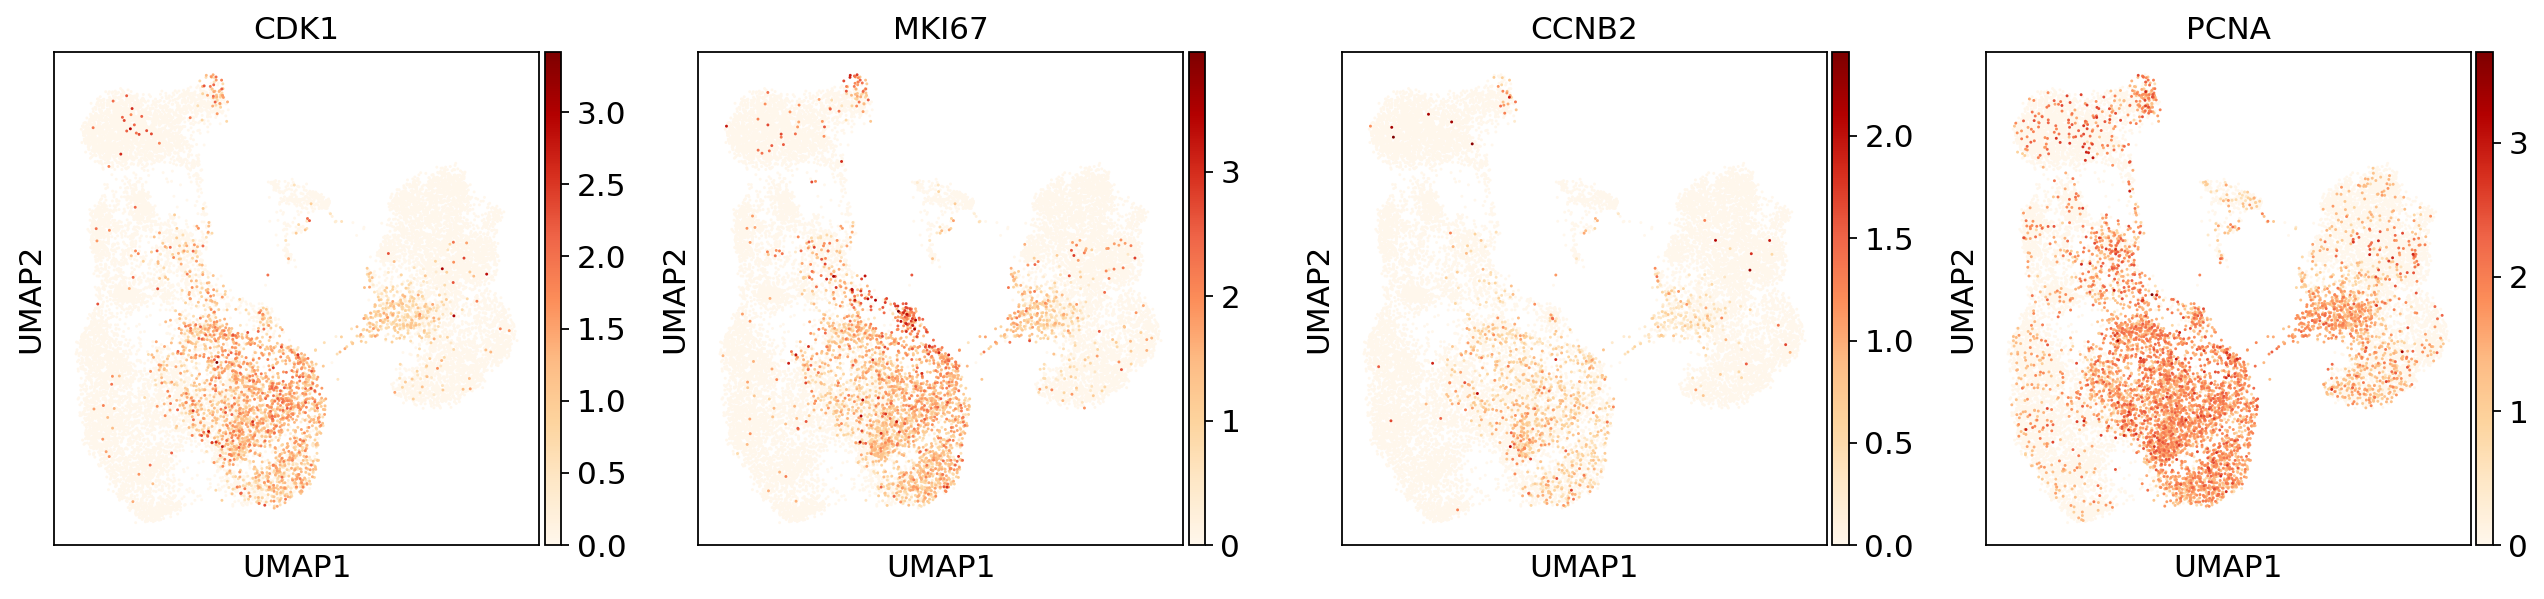

In [85]:
sc.pl.umap(adata_hvg, color=['CDK1','MKI67','CCNB2','PCNA'], cmap='OrRd')

In [86]:
adata_hvg

AnnData object with n_obs × n_vars = 17315 × 2439 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'ccgs', 'pca', 'neighbors', 'activation_colors', 'sample_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

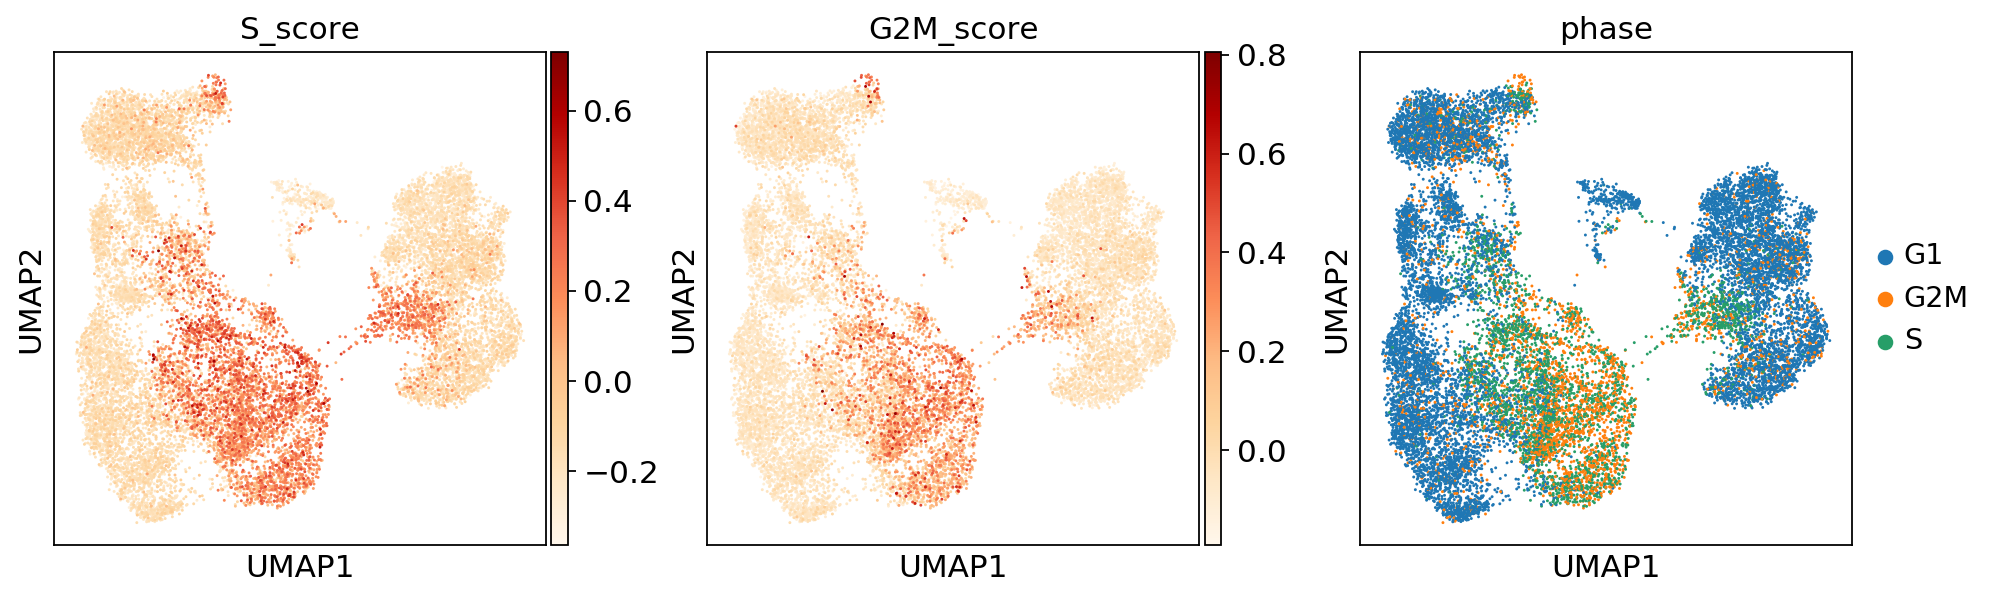

In [87]:
sc.pl.umap(adata_hvg, color=['S_score','G2M_score','phase'], cmap='OrRd')

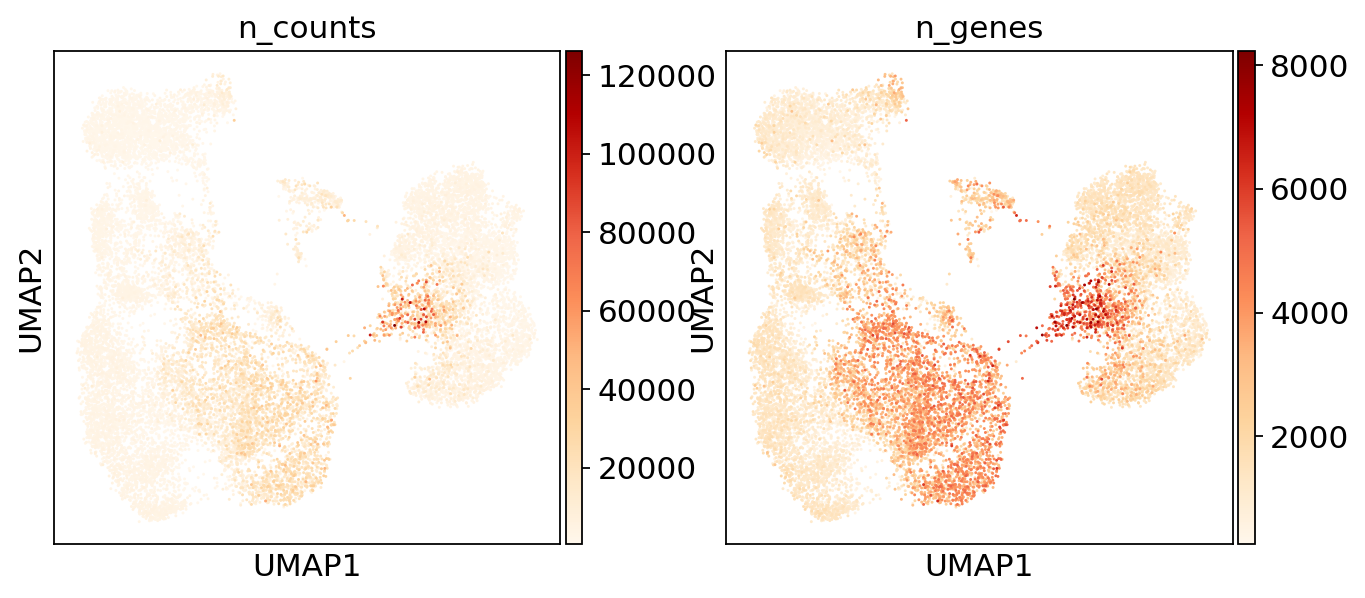

In [88]:
sc.pl.umap(adata_hvg, color=['n_counts',
                             'n_genes'], cmap='OrRd')

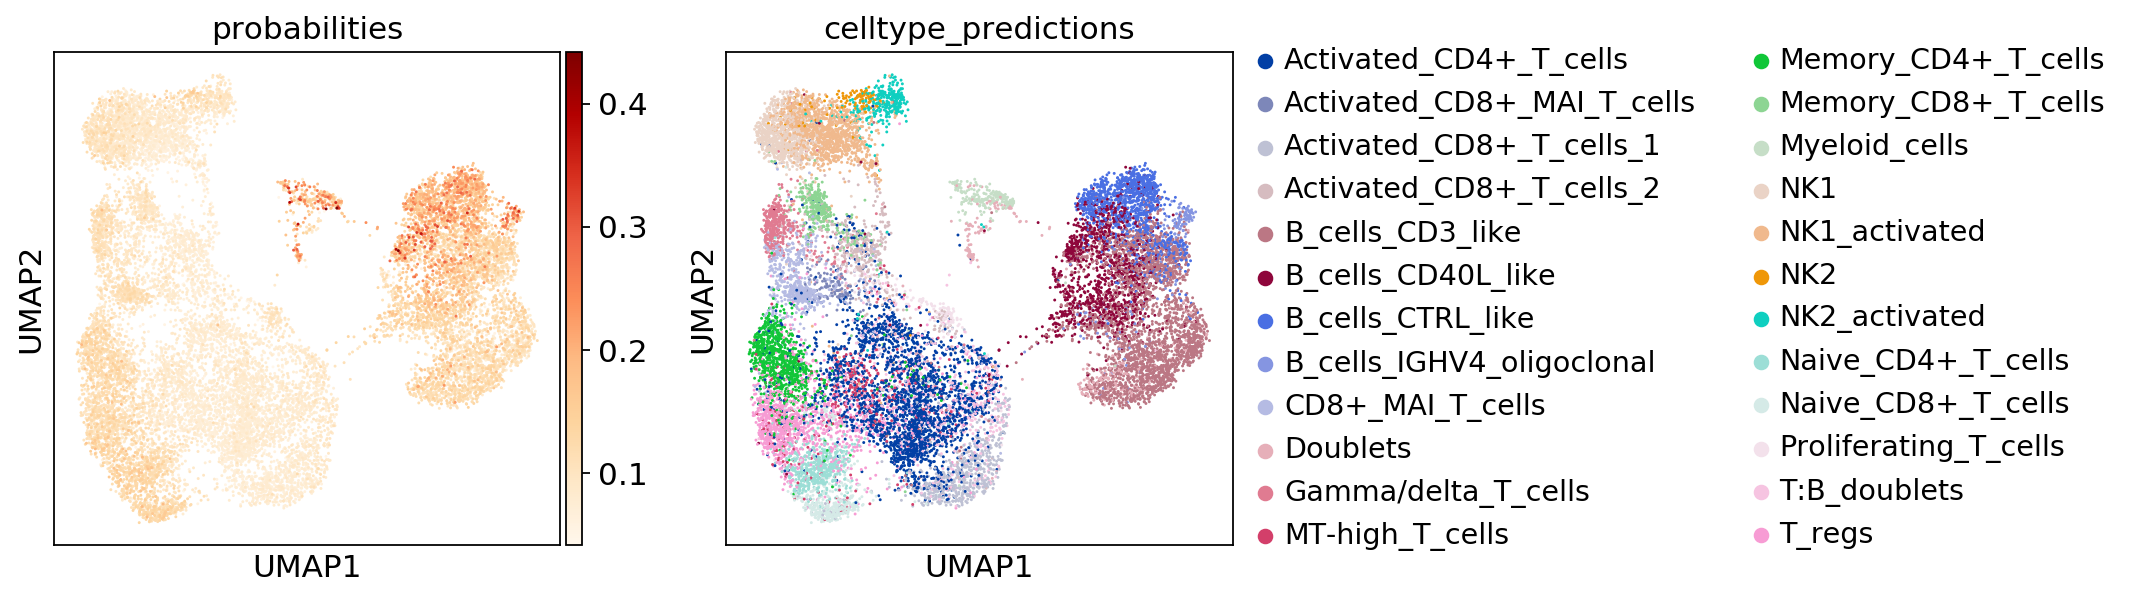

In [89]:
sc.pl.umap(adata_hvg, color=['probabilities','celltype_predictions'], cmap='OrRd')

### Unbiased clustering

In [91]:
%%time
sc.tl.louvain(adata_hvg, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:01)
CPU times: user 1.59 s, sys: 204 ms, total: 1.8 s
Wall time: 1.79 s


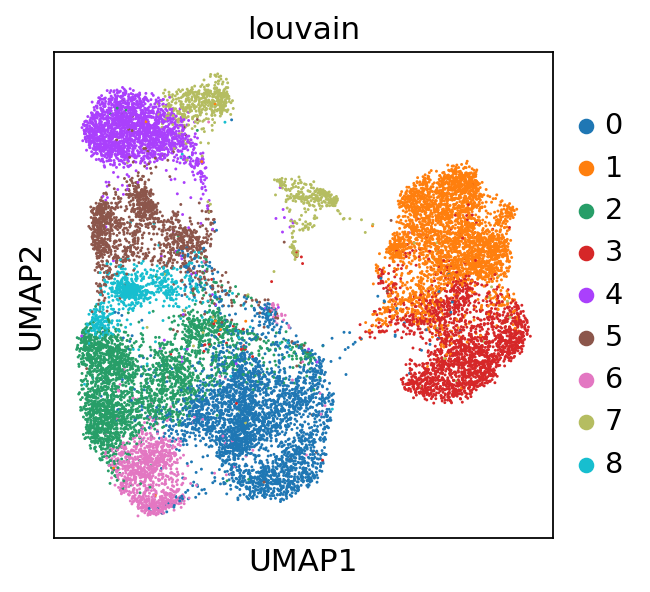

In [92]:
sc.pl.umap(adata_hvg, color=['louvain'])

In [93]:
adata_hvg.write(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs.h5ad')

In [87]:
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_nodoublets_20_PCs.h5ad')

## Preparing the object for cellxgene

In [94]:
adata_full = anndata.AnnData(X=adata_hvg.raw.X,
                            obs=adata_hvg.obs,
                            var=adata_hvg.raw.var,
                            obsm=adata_hvg.obsm)

In [95]:
adata_full

AnnData object with n_obs × n_vars = 17315 × 17976 
    obs: 'activation', 'barcode_sample', 'batch', 'bh_pval', 'condition', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet', 'S_score', 'G2M_score', 'phase', 'probabilities', 'celltype_predictions', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5'
    obsm: 'X_pca', 'X_umap'

In [97]:
import scipy
adata_full.X = scipy.sparse.csc_matrix(adata_full.X)


In [98]:
adata_full.obs.columns

Index(['activation', 'barcode_sample', 'batch', 'bh_pval', 'condition',
       'n_counts', 'n_genes', 'percent_mito', 'sample',
       'scrublet_cluster_score', 'scrublet_score', 'technique', 'is_doublet',
       'S_score', 'G2M_score', 'phase', 'probabilities',
       'celltype_predictions', 'louvain'],
      dtype='object')

In [99]:
categ_columns = ['activation', 'batch', 'condition',
        'sample', 'phase', 'celltype_predictions', 'louvain']

cont_columns = ['n_counts', 'n_genes', 'percent_mito','scrublet_cluster_score',
                'scrublet_score', 'S_score', 'G2M_score', 'probabilities'
               ]


In [100]:
import pandas
for column in categ_columns:
    adata_full.obs[column] = pd.Categorical(adata_full.obs[column])
    
for column in cont_columns:
    adata_full.obs[column] = np.float32(adata_full.obs[column])

In [102]:
adata_full.write(save_path + 'adata_BBKNN_by_sample_twins_reanalysed_for_cellxgene.h5ad')

In [103]:
save_path

'/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/202102_twins_reanalysis/'